In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from numpy import mean, std

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# ignore known warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=UserWarning)

In [2]:
# load in the dataset
features = pd.read_csv('heloc_dataset_v1.csv')

# Remove rows with missing values
df = features.drop(["RiskPerformance"], axis=1)

# Remove rows with the same value (all -9s)
rows_with_missing_values = df[df.apply(lambda x: min(x) == max(x), 1)]
features = features.drop(rows_with_missing_values.index.tolist())
features = features.reset_index(drop=True)

# Drop columns with correlation over 0.8 with lower feature importance
to_remove = ['NumTotalTrades', 'NumTrades90Ever/DerogPubRec', 'NumInqLast6Mexcl7days'] 
features = features.drop(to_remove, axis=1)

X = features[features.columns[1:]]
y = features["RiskPerformance"]

# columns categorization
categorical = ['MaxDelqEver', 'MaxDelq/PublicRecLast12M']
numerical = [col for col in X.columns if col not in categorical]

# Encode labels
y_code = y.astype("category").cat.codes

for cat in categorical:
    features[cat] = features[cat].astype("category")

In [3]:
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

model = RandomForestClassifier(n_estimators = 200, n_jobs=-1, max_features='sqrt')

transformer = ColumnTransformer(transformers=[('num', StandardScaler(), numerical), ('cat', OrdinalEncoder(), categorical)])

In [4]:
columns = list(numerical) + list(categorical)

X_transform = pd.DataFrame(transformer.fit_transform(X), columns=columns)

X_train_transformed, X_test_transformed, y_train, y_test = \
    train_test_split(X_transform, y_code, stratify=y_code, train_size = 0.9, random_state=0)

X_train, X_test, y_train, y_test = train_test_split(X, y_code, stratify=y_code, train_size = 0.9, random_state=0)

In [5]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
labelled_correctly = y_pred == y_test
y_pred_prob = model.predict_proba(X_test)[:, 1]

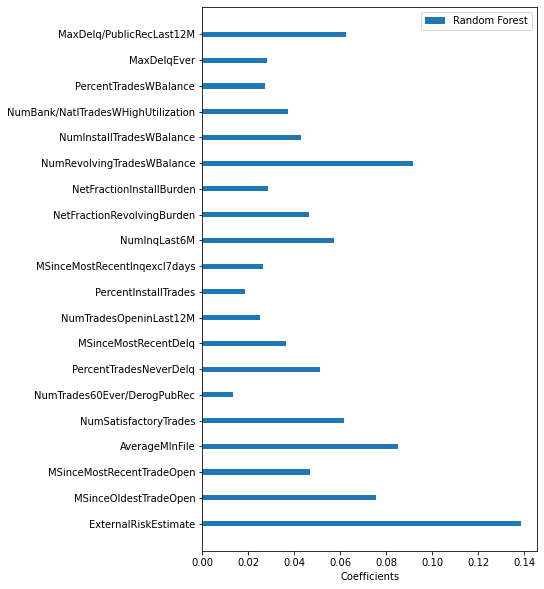

In [6]:
# Feature importances
df = pd.DataFrame({'names': columns, 
                   'random_forest': model.feature_importances_})

fig, ax = plt.subplots(figsize=(6, 10))
ind = np.arange(len(df))
width = 0.2
ax.barh(ind, df.random_forest, width, label='Random Forest')
ax.set_yticklabels(columns)
ax.set_yticks(np.arange(len(columns)))
ax.set_xlabel('Coefficients')
ax.legend()
plt.show()

Text(0.5, 1.0, 'Permutation Importances (test set)')

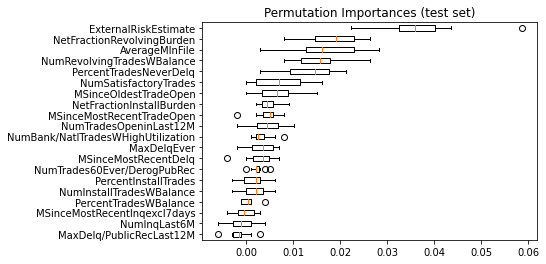

In [7]:
# Permutation Importances
from sklearn.inspection import permutation_importance
 
perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=0) # Takes a long time
sorted_idx = perm_importance.importances_mean.argsort()
plt.boxplot(perm_importance.importances[sorted_idx].T, vert=False, labels=np.array(columns)[sorted_idx])
plt.title("Permutation Importances (test set)")

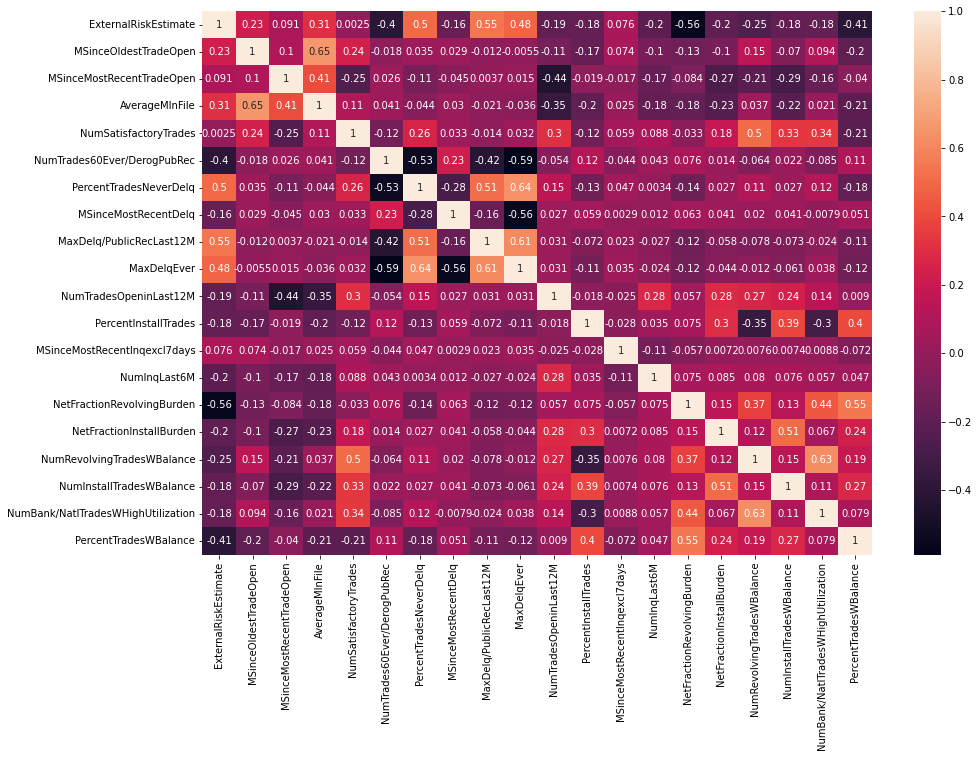

In [8]:
# Correlation matrix
import seaborn as sn
corrMatrix = X_train.corr()
plt.figure(figsize=(15, 10))
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [9]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt 

X_embed = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X_test_transformed)

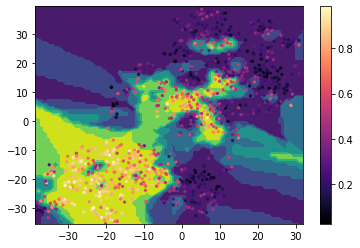

In [25]:
# Decision boundary using Voronoi tesselation
from sklearn.neighbors import KNeighborsClassifier

# create meshgrid
resolution = 80 
X2d_xmin, X2d_xmax = np.min(X_embed[:,0]), np.max(X_embed[:,0])
X2d_ymin, X2d_ymax = np.min(X_embed[:,1]), np.max(X_embed[:,1])
xx, yy = np.meshgrid(np.linspace(X2d_xmin, X2d_xmax, resolution), np.linspace(X2d_ymin, X2d_ymax, resolution))

# approximate Voronoi tesselation on resolution x resolution grid using KNN
background_model = KNeighborsClassifier(n_neighbors=5).fit(X_embed, y_pred) 
voronoiBackground = background_model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
voronoiBackground = voronoiBackground.reshape((resolution, resolution))

#plot
plt.contourf(xx, yy, voronoiBackground, cmap='magma')
plt.scatter(X_embed[:,0], X_embed[:,1], c=y_pred_prob, s=5, cmap='magma')
plt.colorbar()
plt.show()

In [24]:
''' Source: https://github.com/PanWu/pylib/blob/master/pylib/plot.py
    Develop a function to visualize decision boundary
        for any classification models in 2D
'''

from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


def retrieve_n_class_color_cubic(N):
    '''
    retrive color code for N given classes
    Input: class number
    Output: list of RGB color code
    '''

    # manualy encode the top 8 colors
    # the order is intuitive to be used
    color_list = [
        (1, 0, 0),
        (0, 1, 0),
        (0, 0, 1),
        (1, 1, 0),
        (0, 1, 1),
        (1, 0, 1),
        (0, 0, 0),
        (1, 1, 1)
    ]

    # if N is larger than 8 iteratively generate more random colors
    np.random.seed(1)  # pre-define the seed for consistency

    interval = 0.5
    while len(color_list) < N:
        the_list = []
        iterator = np.arange(0, 1.0001, interval)
        for i in iterator:
            for j in iterator:
                for k in iterator:
                    if (i, j, k) not in color_list:
                        the_list.append((i, j, k))
        the_list = list(set(the_list))
        np.random.shuffle(the_list)
        color_list.extend(the_list)
        interval = interval / 2.0

    return color_list[:N]


def plot_decision_boundary(model, dim_red_method='pca',
                           X=None, Y=None,
                           xrg=None, yrg=None,
                           Nx=300, Ny=300,
                           scatter_sample=None,
                           figsize=[6, 6], alpha=0.7,
                           random_state=111):
    '''
    Plot decision boundary for any two dimension classification models
        in sklearn.
    Input:
        model: sklearn classification model class - already fitted
                (with "predict" and "predict_proba" method)
        dim_red_method: sklearn dimension reduction model
                (with "fit_transform" and "inverse_transform" method)
        xrg (list/tuple): xrange
        yrg (list/tuple): yrange
        Nx (int): x axis grid size
        Ny (int): y axis grid size
        X (nparray): dataset to project over decision boundary (X)
        Y (nparray): dataset to project over decision boundary (Y)
        figsize, alpha are parameters in matplotlib
    Output:
        matplotlib figure object
    '''

    # check model is legit to use
    try:
        getattr(model, 'predict')
    except:
        print("model do not have method predict 'predict' ")
        return None

    use_prob = True
    try:
        getattr(model, 'predict_proba')
    except:
        print("model do not have method predict 'predict_proba' ")
        use_prob = False

    # convert X into 2D data
    ss, dr_model = None, None
    if X is not None:
        if X.shape[1] == 2:
            X2D = X
        elif X.shape[1] > 2:
            # leverage PCA to dimension reduction to 2D if not already
            ss = StandardScaler()
            if dim_red_method == 'pca':
                dr_model = PCA(n_components=2)
            elif dim_red_method == 'kernal_pca':
                dr_model = KernelPCA(n_components=2,
                                     fit_inverse_transform=True)
            else:
                print('dim_red_method {0} is not supported'.format(
                    dim_red_method))

            X2D = dr_model.fit_transform(ss.fit_transform(X))
        else:
            print('X dimension is strange: {0}'.format(X.shape))
            return None

        # extract two dimension info.
        x1 = X2D[:, 0].min() - 0.1 * (X2D[:, 0].max() - X2D[:, 0].min())
        x2 = X2D[:, 0].max() + 0.1 * (X2D[:, 0].max() - X2D[:, 0].min())
        y1 = X2D[:, 1].min() - 0.1 * (X2D[:, 1].max() - X2D[:, 1].min())
        y2 = X2D[:, 1].max() + 0.1 * (X2D[:, 1].max() - X2D[:, 1].min())

    # inti xrg and yrg based on given value
    if xrg is None:
        if X is None:
            xrg = [-10, 10]
        else:
            xrg = [x1, x2]

    if yrg is None:
        if X is None:
            yrg = [-10, 10]
        else:
            yrg = [y1, y2]

    # generate grid, mesh, and X for model prediction
    xgrid = np.arange(xrg[0], xrg[1], 1. * (xrg[1] - xrg[0]) / Nx)
    ygrid = np.arange(yrg[0], yrg[1], 1. * (yrg[1] - yrg[0]) / Ny)

    xx, yy = np.meshgrid(xgrid, ygrid)
    X_full_grid = np.array(list(zip(np.ravel(xx), np.ravel(yy))))

    # initialize figure & axes object
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(1, 1, 1)

    # get data from model predictions
    if dr_model is None:
        Yp = model.predict(X_full_grid)
        if use_prob:
            Ypp = model.predict_proba(X_full_grid)
        else:
            Ypp = pd.get_dummies(Yp).values
    else:
        X_full_grid_inverse = ss.inverse_transform(
            dr_model.inverse_transform(X_full_grid))

        Yp = model.predict(X_full_grid_inverse)
        if use_prob:
            Ypp = model.predict_proba(X_full_grid_inverse)
        else:
            Ypp = pd.get_dummies(Yp).values

    # retrieve n class from util function
    nclass = Ypp.shape[1]
    colors = np.array(retrieve_n_class_color_cubic(N=nclass))

    # get decision boundary line
    Yp = Yp.reshape(xx.shape)
    Yb = np.zeros(xx.shape)

    Yb[:-1, :] = np.maximum((Yp[:-1, :] != Yp[1:, :]), Yb[:-1, :])
    Yb[1:, :] = np.maximum((Yp[:-1, :] != Yp[1:, :]), Yb[1:, :])
    Yb[:, :-1] = np.maximum((Yp[:, :-1] != Yp[:, 1:]), Yb[:, :-1])
    Yb[:, 1:] = np.maximum((Yp[:, :-1] != Yp[:, 1:]), Yb[:, 1:])

    # plot decision boundary first
    ax.imshow(Yb, origin='lower', interpolation=None, cmap='Greys',
              extent=[xrg[0], xrg[1], yrg[0], yrg[1]],
              alpha=1.0)

    # plot probability surface
    zz = np.dot(Ypp, colors[:nclass, :])
    zz_r = zz.reshape(xx.shape[0], xx.shape[1], 3)
    ax.imshow(zz_r, origin='lower', interpolation=None,
              extent=[xrg[0], xrg[1], yrg[0], yrg[1]],
              alpha=alpha)

    # add scatter plot for X & Y if given
    if X is not None:
        # down sample point if needed
        if Y is not None:
            if scatter_sample is not None:
                X2DS, _, YS, _ = train_test_split(X2D, Y, stratify=Y,
                                                  train_size=scatter_sample,
                                                  random_state=random_state)
            else:
                X2DS = X2D
                YS = Y
        else:
            if scatter_sample is not None:
                X2DS, _ = train_test_split(X2D, train_size=scatter_sample,
                                           random_state=random_state)
            else:
                X2DS = X2D

        # convert Y into point color
        if Y is not None:
            # presume Y is labeled from 0 to N-1
            cYS = [colors[i] for i in YS]

        if Y is not None:
            ax.scatter(X2DS[:, 0], X2DS[:, 1], c=cYS)
        else:
            ax.scatter(X2DS[:, 0], X2DS[:, 1])

    # add legend on each class
    colors_bar = []
    for v1 in colors[:nclass, :]:
        v1 = list(v1)
        v1.append(alpha)
        colors_bar.append(v1)

    # create a patch (proxy artist) for every color
    patches = [mpatches.Patch(color=colors_bar[i],
                              label="Class {k}".format(k=i))
               for i in range(nclass)]
    # put those patched as legend-handles into the legend
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1),
               loc=2, borderaxespad=0., framealpha=0.5)

    # make the figure nicer
    ax.set_title('Classification decision boundary')
    if dr_model is None:
        ax.set_xlabel('Raw axis X')
        ax.set_ylabel('Raw axis Y')
    else:
        ax.set_xlabel('Dimension reduced axis 1')
        ax.set_ylabel('Dimension reduced axis 2')
    ax.set_xlim(xrg)
    ax.set_ylim(yrg)
    ax.set_xticks(np.arange(xrg[0], xrg[1], (xrg[1] - xrg[0])/5.))
    ax.set_yticks(np.arange(yrg[0], yrg[1], (yrg[1] - yrg[0])/5.))
    ax.grid(True)

    return fig, ss, dr_model

(<Figure size 432x432 with 1 Axes>, StandardScaler(), PCA(n_components=2))

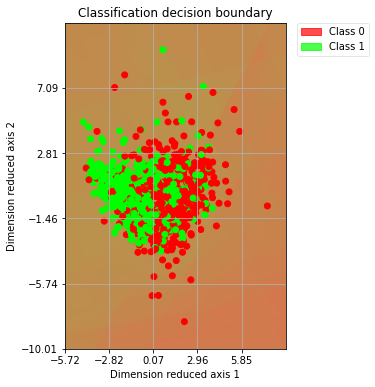

In [26]:
plot_decision_boundary(model, X=X_test_transformed, Y=y_test)

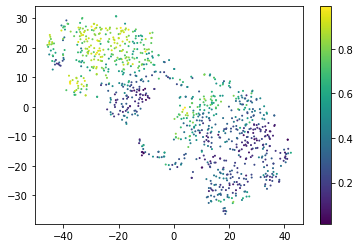

In [11]:
# Plot prediction probabilities across samples - also allow for other params!
plt.scatter(X_embed[:, 0], X_embed[:, 1], c=y_pred_prob, s=1)
plt.colorbar()

In [ ]:
# labels - any of the col names
labels = X_test['ExternalRiskEstimate'].tolist()
plt.scatter(X_embed[:, 0], X_embed[:, 1], c=labels, s=1)
plt.colorbar()

In [ ]:
labels = X_test[categorical[0]].tolist()
plt.scatter(X_embed[:, 0], X_embed[:, 1], c=labels, s=1)
plt.colorbar()

In [14]:
# SHAP model (and local) explanations
import shap 

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)[1] #Takes a very long time

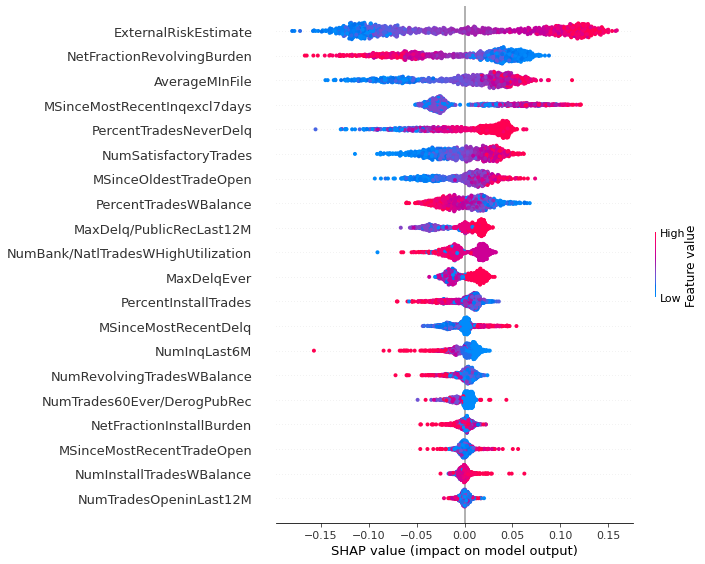

In [15]:
shap.summary_plot(shap_values, X_test)

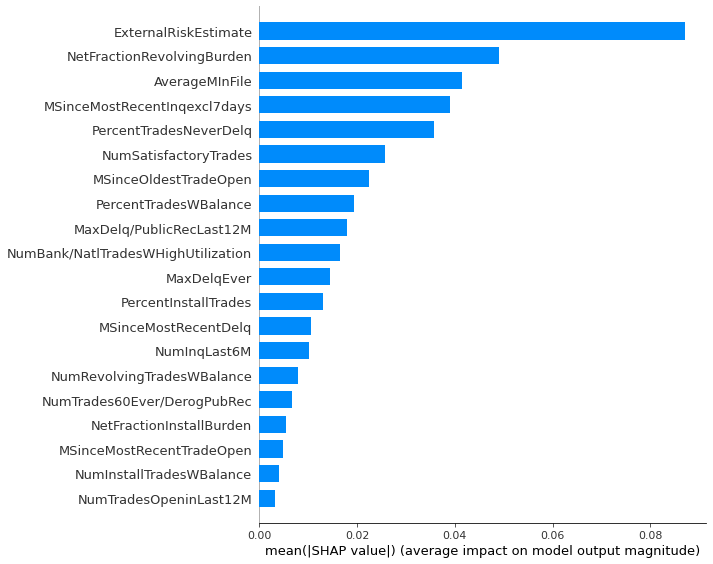

In [16]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [17]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[0,:], X_test.iloc[0,:])

In [18]:
# Lime Local explanations
from lime.lime_tabular import LimeTabularExplainer

explainer = LimeTabularExplainer(
    X_train.values, 
    mode='classification', 
    feature_names=X_train.columns, 
    verbose=True
)

In [39]:
exp = explainer.explain_instance(X_test.loc[3610], model.predict_proba)
exp.show_in_notebook(show_table=True)

Intercept 0.46854231897290183
Prediction_local [0.48736808]
Right: 0.505


In [20]:
exp.as_list()

[('ExternalRiskEstimate > 80.00', 0.0913259935422284),
 ('MSinceMostRecentInqexcl7days <= 0.00', -0.05849053456581762),
 ('97.00 < PercentTradesNeverDelq <= 100.00', 0.049903695864087695),
 ('NumSatisfactoryTrades > 28.00', 0.0360815368076288),
 ('8.00 < NetFractionRevolvingBurden <= 28.00', 0.027969463604043312),
 ('MaxDelq/PublicRecLast12M <= 5.00', -0.02789714821262088),
 ('NumInqLast6M > 2.00', -0.02091556644008087),
 ('PercentTradesWBalance > 83.00', -0.020738898145362894),
 ('6.00 < MaxDelqEver <= 8.00', 0.018286277748005418),
 ('NumBank/NatlTradesWHighUtilization <= 0.00', 0.01807786542829744)]

In [46]:
pd.DataFrame(d)

,Explanation,Probability attributed
0,MSinceMostRecentInqexcl7days <= 0.00,-0.062391
1,97.00 < PercentTradesNeverDelq <= 100.00,0.051039
2,64.00 < ExternalRiskEstimate <= 72.00,-0.041939
3,MSinceOldestTradeOpen > 256.00,0.033803
4,6.00 < MaxDelq/PublicRecLast12M <= 7.00,0.019267
5,PercentTradesWBalance <= 50.00,0.019263
6,6.00 < MaxDelqEver <= 8.00,0.014204
7,1.00 < NumInqLast6M <= 2.00,-0.011811
8,13.00 < NumSatisfactoryTrades <= 20.00,-0.011065
9,PercentInstallTrades <= 21.00,0.008455


In [51]:
import plotly.express as px


explanations = [e[0] for e in exp.as_list()]
prob_values = [e[1] for e in exp.as_list()]
impact = ['positive' if e[1] > 0 else 'negative' for e in exp.as_list()]
d = {
    "Explanation": explanations,
    "Probability attributed": prob_values,
    "Impact": impact
}
fig = px.bar(
    data_frame=pd.DataFrame(d),
    y="Explanation",
    x="Probability attributed",
    orientation='h',
    color="Impact"
)
fig.show()

In [21]:
exp.predict_proba

array([0.375, 0.625])

In [36]:
# DiCE counterfactual explanations
from dice_ml import Data, Model, Dice

df = X_train.copy()
df['y'] = y_train.copy()
data = Data(
    dataframe=df, 
    continuous_features=numerical, 
    outcome_name='y'
)
m = Model(model=model, backend='sklearn')
dice = Dice(data, m, method='random')
e = dice.generate_counterfactuals(X_test.loc[[3610]], total_CFs=1, desired_class="opposite")

# As an improvement point for the future work in the report - 
# would be great if we could get counterfactual probability as well, it is a work in progress in the DiCE library

import json

d = json.loads(e.to_json())
cfs_list = d['cfs_list'][0][0][:20]
test_data = d['test_data'][0][0][:20]
cf_df = pd.DataFrame([test_data, cfs_list], columns=d['feature_names'], index=['Actual', 'Closest CounterFactual'])
nunique = cf_df.nunique()
cols_to_drop = nunique[nunique == 1].index
cf_df.drop(cols_to_drop, axis=1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.38it/s]


,PercentInstallTrades,NetFractionRevolvingBurden
Actual,15,51
Closest CounterFactual,96,24


In [35]:
X_test.loc[[3610]]

,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever/DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,MaxDelq/PublicRecLast12M,MaxDelqEver,NumTradesOpeninLast12M,PercentInstallTrades,MSinceMostRecentInqexcl7days,NumInqLast6M,NetFractionRevolvingBurden,NetFractionInstallBurden,NumRevolvingTradesWBalance,NumInstallTradesWBalance,NumBank/NatlTradesWHighUtilization,PercentTradesWBalance
3610,72,334,2,69,19,0,100,-7,7,8,4,15,0,2,51,-8,3,-8,1,50


In [54]:
cols = [
    "NumTrades60Ever/DerogPubRec",
    "NumTradesOpeninLast12M",
    "NumInqLast6M",
    "NumRevolvingTradesWBalance",
    "NumInstallTradesWBalance",
    "NumBank/NatlTradesWHighUtilization",
    "NumSatisfactoryTrades"
]
fig = px.scatter_matrix(
    data_frame=df,
    dimensions=cols,
    color="NumInqLast6M"
)
fig.show()